In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split

# Cargar el conjunto de datos
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(newsgroups.data, newsgroups.target, test_size=0.4, random_state=42)

# Dividir el conjunto de entrenamiento en subconjuntos con superposición
def create_overlapping_subsets(X, y, subset_size=1500, overlap=500, num_subsets=11):
    subsets_X = []
    subsets_y = []
    start = 0

    for i in range(num_subsets):
        end = start + subset_size if i < num_subsets - 1 else len(X)
        subsets_X.append(X[start:end])
        subsets_y.append(y[start:end])
        start = end - overlap if i < num_subsets - 1 else len(X)
    return subsets_X, subsets_y

subsets_X_train, subsets_y_train = create_overlapping_subsets(X_train, y_train)


In [2]:
[len(subsets_X_train[i]) for i in range(11)]

[1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1307]

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Crear la matriz TF-IDF para cada subconjunto
tfidf_vectorizer = TfidfVectorizer(max_features=None)  # Sin limitar el número de características
tfidf_global = tfidf_vectorizer.fit_transform(X_train)
subsets_tfidf = [tfidf_vectorizer.transform(subset).toarray() for subset in subsets_X_train]

In [4]:
[subsets_tfidf[i][0] for i in range(11)]

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.])]

In [5]:
subsets_tfidf[0].shape

(1500, 96465)

In [ ]:
# Import librería para simular SNN
from brian2 import *

start_scope()

# Asumiendo que tfidf_matrix ya está definida y es accesible
tfidf_matrix = subsets_tfidf[0]

# Número de neuronas en la primera capa, basado en la cantidad de características TF-IDF
# NIN: Neuron input number
NIN = tfidf_matrix.shape[1]

# Número de neuronas en la capa oculta (NHN: Neuron hidden number)
NHN = 50

# Coeficiente de proporcionalidad para las tasas de disparo
alpha = 1.5

# Parámetros del modelo LIF
tau = 100*ms
u_rest = -65*mV
u_exc = 0*mV
u_inh = -90*mV
u_th = -52*mV
t_ref = 3*ms
tau_e = 2*ms
tau_i = 2*ms

# Constante de tiempo de traza presináptica
tau_A = 5*ms

# Constante de tiempo de traza postsináptica
tau_R = 70*ms

# Constante de aprendizaje
n = 0.01

# Peso máximo
w_max = 1

# Modelo de neurona LIF
eqs = '''
                du/dt = ((u_rest - u) + g_e*(u_exc - u) + g_i*(u_inh - u)) / tau : volt (unless refractory)
                dg_e/dt = -g_e / tau_e : 1
                dg_i/dt = -g_i / tau_i : 1
                '''

# Inicializando pesos
S_initial = np.random.uniform(low=0, high=0.1, size=(1, NIN*NHN))

for doc in range(tfidf_matrix.shape[0]):
  # Entrada
  rates = tfidf_matrix[doc] * alpha * Hz
  P = PoissonGroup(NIN, rates=rates)

  # Capa oculta
  G = NeuronGroup(NHN, eqs, threshold='u > u_th', reset='u = u_rest',
                  refractory=t_ref, method='euler')

  # Sinapsis P - G
  # Plasticidad STDP
  eqs_plasticity = '''
                  dA/dt = -A / tau_A : 1 (event-driven)
                  dR/dt = -R / tau_R : 1 (event-driven)
                  w : 1
                  '''
  on_pre = '''
                  A += 1
                  w = clip(w + (n * (A - (R + 0.1) * w)), 0, w_max)
                  '''
  on_post = '''
                  R += 1
                  '''
  S = Synapses(P, G, model=eqs_plasticity, on_pre=on_pre, on_post=on_post)
  S.connect()
  S.w = S_initial

  M_spikes = SpikeMonitor(G)
  M = StateMonitor(G, 'u', record=True)

  spikemon_in = SpikeMonitor(P) #records spikes from input neurons
  spikemon_out = SpikeMonitor(G) #records spikes from output neurons
  run(600*ms)

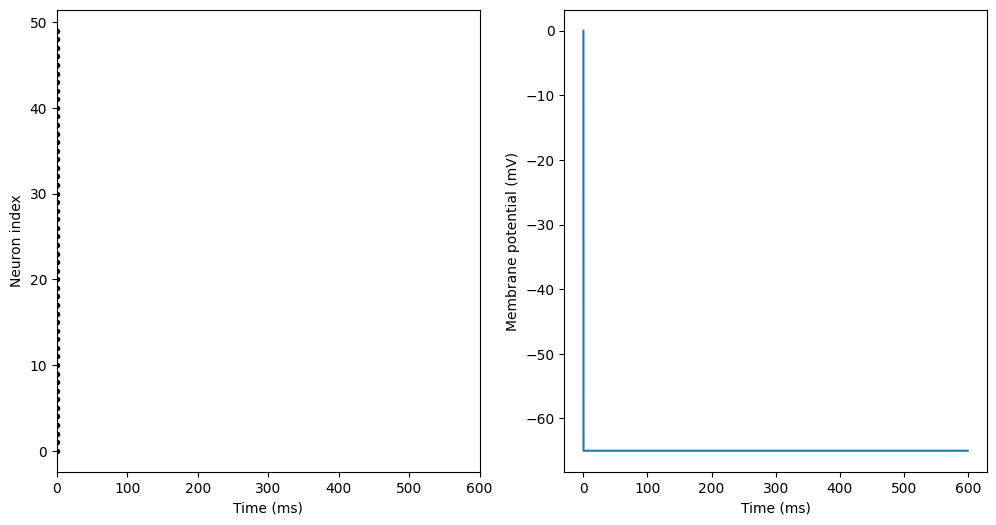

In [9]:
# Visualización
figure(figsize=(12, 6))
subplot(121)
plot(M_spikes.t/ms, M_spikes.i, '.k')
xlim(0, 600)
xlabel('Time (ms)')
ylabel('Neuron index')

subplot(122)
plot(M.t/ms, M.u[0]/mV)
xlabel('Time (ms)')
ylabel('Membrane potential (mV)')

show()

In [10]:
print('No of spikes from input : {}'.format(spikemon_in.num_spikes))
print('No of spikes from output : {}'.format(spikemon_out.num_spikes))

No of spikes from input : 4
No of spikes from output : 50


In [14]:
spikemon_in.

'thresholds'